# Capstone Project – Finding a Better Place in Etobicoke, Toronto

## 1. Installing and Importing Python Libraries and Dependencies

In [1]:
!pip install geocoder
!pip install folium
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

print("All Libraries Imported!")

     |████████████████████████████████| 98 kB 9.7 MB/s  eta 0:00:01
     |████████████████████████████████| 94 kB 6.4 MB/s  eta 0:00:01
All Libraries Imported!


## 2. Data Extraction and Cleaning
Using BeautifulSoup Scraping List of Postal Codes of Given Wikipedia Page. Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [2]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source,'lxml')

In [3]:
table_contents = []
table = soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text == "Not assigned":
        pass
    else :
        cell['Postalcode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace('/',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

In [4]:
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway , Montgomery Road , Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South , King's Mill Park , Sunnylea ,..."


In [6]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_c72c915303314c4eb0eb6e59ed259c78 = 'https://s3.eu-geo.objectstorage.softlayer.net'
else:
    endpoint_c72c915303314c4eb0eb6e59ed259c78 = 'https://s3.eu-geo.objectstorage.service.networklayer.com'

client_c72c915303314c4eb0eb6e59ed259c78 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='cBrIWj4t5GosPd2SvUvqdzmg6tiG7WKnUAKk6nNHuIA9',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_c72c915303314c4eb0eb6e59ed259c78)

body = client_c72c915303314c4eb0eb6e59ed259c78.get_object(Bucket='pythonbasicsfordatascienceproject-donotdelete-pr-1m0uovsg2efiaa',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

geo_df = pd.read_csv(body)
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
geo_df.rename(columns={'Postal Code':'Postalcode'},inplace=True)
geo_merged = pd.merge(df, geo_df, on='Postalcode')
geo_merged.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [28]:
df_2 = geo_merged[geo_merged['Borough']=='Etobicoke']
df_2

,Postalcode,Borough,Neighborhood,Latitude,Longitude
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
11,M9B,Etobicoke,"West Deane Park , Princess Gardens , Martin Gr...",43.650943,-79.554724
17,M9C,Etobicoke,"Eringate , Bloordale Gardens , Old Burnhamthor...",43.643515,-79.577201
70,M9P,Etobicoke,Westmount,43.696319,-79.532242
77,M9R,Etobicoke,"Kingsview Village , St. Phillips , Martin Grov...",43.688905,-79.554724
88,M8V,Etobicoke,"New Toronto , Mimico South , Humber Bay Shores",43.605647,-79.501321
89,M9V,Etobicoke,"South Steeles , Silverstone , Humbergate , Jam...",43.739416,-79.588437
93,M8W,Etobicoke,"Alderwood , Long Branch",43.602414,-79.543484
98,M8X,Etobicoke,"The Kingsway , Montgomery Road , Old Mill North",43.653654,-79.506944
101,M8Y,Etobicoke,"Old Mill South , King's Mill Park , Sunnylea ,...",43.636258,-79.498509


In [29]:
address = 'Etobicoke,Toronto'

geolocator = Nominatim(user_agent="smy-application")
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.6896191, -79.479188.


## 3. Map of Etobicoke

In [30]:
map_Etobicoke = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Etobicoke)  
    
map_Etobicoke

In [31]:
CLIENT_ID = 'AVQ1YZBO2VK5Z2F3C22020P1IRK1F1YPE1LKIM0H0MJWNERS' # my Foursquare ID
CLIENT_SECRET = 'B3UTBVSPCFBYCXOFGSF4WDZRXFVLKON4RDTPDBV10DEFQZWW' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: AVQ1YZBO2VK5Z2F3C22020P1IRK1F1YPE1LKIM0H0MJWNERS
CLIENT_SECRET: B3UTBVSPCFBYCXOFGSF4WDZRXFVLKON4RDTPDBV10DEFQZWW


In [32]:
radius = 500 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [33]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app


Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.crossStreet', 'venue.location.lat',
       'venue.location.lng', 'venue.location.labeledLatLngs',
       'venue.location.distance', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups', 'venue.location.address',
       'venue.location.postalCode', 'venue.location.neighborhood',
       'venue.venuePage.id'],
      dtype='object')

In [34]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## 4. Nearby Venues/Locations

In [35]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Farmer's Market Etobicoke,"[{'id': '4bf58dd8d48988d1fa941735', 'name': 'F...",43.643061,-79.566191
1,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.644742,-79.567680
2,Loblaws,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",43.643848,-79.560113
3,State & Main Kitchen & Bar,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.645778,-79.560374
4,Quiznos,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",43.642068,-79.565450


## 5. Categories of Nearby Venues/Locations

In [36]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Farmer's Market Etobicoke,Farmers Market,43.643061,-79.566191
1,Tim Hortons,Coffee Shop,43.644742,-79.567680
2,Loblaws,Grocery Store,43.643848,-79.560113
3,State & Main Kitchen & Bar,Restaurant,43.645778,-79.560374
4,Quiznos,Sandwich Place,43.642068,-79.565450


In [37]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Restaurant                1
Clothing Store            1
Transportation Service    1
Skating Rink              1
Coffee Shop               1
Grocery Store             1
Hotel                     1
Convenience Store         1
Sandwich Place            1
Farmers Market            1
Name: categories, dtype: int64

In [38]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
# Nearby Venues
Etobicoke_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Islington Avenue
West Deane Park , Princess Gardens , Martin Grove , Islington , Cloverdale
Eringate , Bloordale Gardens , Old Burnhamthorpe , Markland Wood
Westmount
Kingsview Village , St. Phillips , Martin Grove Gardens , Richview Gardens
New Toronto , Mimico South , Humber Bay Shores
South Steeles , Silverstone , Humbergate , Jamestown , Mount Olive , Beaumond Heights , Thistletown , Albion Gardens
Alderwood , Long Branch
The Kingsway , Montgomery Road , Old Mill North
Old Mill South , King's Mill Park , Sunnylea , Humber Bay , Mimico NE , The Queensway East , Royal York South East , Kingsway Park South East
Mimico NW , The Queensway West , South of Bloor , Kingsway Park South West , Royal York South West


In [40]:
print('There are {} Uniques Categories.'.format(len(Etobicoke_venues['Venue Category'].unique())))
Etobicoke_venues.groupby('Neighborhood').count().head()

There are 60 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Alderwood , Long Branch",10,10,10,10,10,10
"Eringate , Bloordale Gardens , Old Burnhamthorpe , Markland Wood",9,9,9,9,9,9
Islington Avenue,9,9,9,9,9,9
"Kingsview Village , St. Phillips , Martin Grove Gardens , Richview Gardens",13,13,13,13,13,13
"Mimico NW , The Queensway West , South of Bloor , Kingsway Park South West , Royal York South West",22,22,22,22,22,22


## One Hot Encoding of Features

In [45]:
# one hot encoding
Etobicoke_onehot = pd.get_dummies(Etobicoke_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Etobicoke_onehot['Neighborhood'] = Etobicoke_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Etobicoke_onehot.columns[-1]] + list(Etobicoke_onehot.columns[:-1])
Etobicoke_onehot = Etobicoke_onehot[fixed_columns]
Etobicoke_grouped = Etobicoke_onehot.groupby('Neighborhood').mean().reset_index()
Etobicoke_onehot.drop('Neighborhood',axis = 1)
Etobicoke_onehot.head(5)

,Neighborhood,American Restaurant,Auto Garage,Bakery,Bank,Bar,Baseball Field,Beer Store,Breakfast Spot,Burger Joint,...,Sandwich Place,Shopping Mall,Skating Rink,Supermarket,Supplement Shop,Sushi Restaurant,Tanning Salon,Theater,Wings Joint,Yoga Studio
0,Islington Avenue,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Islington Avenue,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Islington Avenue,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Islington Avenue,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Islington Avenue,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
num_top_venues = 5
for hood in Etobicoke_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Etobicoke_grouped[Etobicoke_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Alderwood , Long Branch ----
               venue  freq
0  Convenience Store   0.2
1        Pizza Place   0.2
2                Gym   0.1
3        Coffee Shop   0.1
4        Gas Station   0.1


---- Eringate , Bloordale Gardens , Old Burnhamthorpe , Markland Wood ----
               venue  freq
0  Electronics Store  0.11
1               Park  0.11
2        Coffee Shop  0.11
3        Pizza Place  0.11
4           Pharmacy  0.11


---- Islington Avenue ----
           venue  freq
0       Pharmacy  0.22
1   Skating Rink  0.11
2  Shopping Mall  0.11
3           Park  0.11
4           Café  0.11


---- Kingsview Village , St. Phillips , Martin Grove Gardens , Richview Gardens ----
                 venue  freq
0  American Restaurant  0.08
1             Bus Line  0.08
2          Gas Station  0.08
3    Mobile Phone Shop  0.08
4             Pharmacy  0.08


---- Mimico NW , The Queensway West , South of Bloor , Kingsway Park South West , Royal York South West ----
                  venue  f

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Most Common venues near neighborhood

In [48]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Etobicoke_grouped['Neighborhood']

for ind in np.arange(Etobicoke_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Etobicoke_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Alderwood , Long Branch",Convenience Store,Pizza Place,Gym,Skating Rink,Coffee Shop,Pub,Sandwich Place,Gas Station,Beer Store,Baseball Field
1,"Eringate , Bloordale Gardens , Old Burnhamthor...",Pharmacy,Electronics Store,Pizza Place,Coffee Shop,Café,Liquor Store,Park,Pet Store,Beer Store,Elementary School
2,Islington Avenue,Pharmacy,Skating Rink,Café,Playground,Shopping Mall,Park,Bank,Grocery Store,Flea Market,Flower Shop
3,"Kingsview Village , St. Phillips , Martin Grov...",American Restaurant,Sandwich Place,Intersection,Coffee Shop,Chinese Restaurant,Mobile Phone Shop,Gas Station,Pizza Place,Bus Line,Pharmacy
4,"Mimico NW , The Queensway West , South of Bloo...",Italian Restaurant,Yoga Studio,Fast Food Restaurant,Hardware Store,Gym / Fitness Center,Wings Joint,Grocery Store,Food & Drink Shop,Discount Store,Liquor Store


## K-Means Clustering Approach

In [49]:
# Using K-Means to cluster neighborhood into 3 clusters
Etobicoke_grouped_clustering = Etobicoke_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Etobicoke_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0], dtype=int32)

In [50]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Etobicoke_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Etobicoke_merged = Etobicoke_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Etobicoke_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,0,Pharmacy,Skating Rink,Café,Playground,Shopping Mall,Park,Bank,Grocery Store,Flea Market,Flower Shop
11,M9B,Etobicoke,"West Deane Park , Princess Gardens , Martin Gr...",43.650943,-79.554724,2,Pizza Place,Theater,Convenience Store,Caribbean Restaurant,Gas Station,Fried Chicken Joint,Food & Drink Shop,Flower Shop,Flea Market,Fast Food Restaurant
17,M9C,Etobicoke,"Eringate , Bloordale Gardens , Old Burnhamthor...",43.643515,-79.577201,0,Pharmacy,Electronics Store,Pizza Place,Coffee Shop,Café,Liquor Store,Park,Pet Store,Beer Store,Elementary School
70,M9P,Etobicoke,Westmount,43.696319,-79.532242,0,Pizza Place,Sandwich Place,Mobile Phone Shop,Middle Eastern Restaurant,Coffee Shop,Discount Store,Intersection,Ice Cream Shop,Chinese Restaurant,Supermarket
77,M9R,Etobicoke,"Kingsview Village , St. Phillips , Martin Grov...",43.688905,-79.554724,0,American Restaurant,Sandwich Place,Intersection,Coffee Shop,Chinese Restaurant,Mobile Phone Shop,Gas Station,Pizza Place,Bus Line,Pharmacy


## Map of Clusters

In [68]:
kclusters = 5

In [52]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Etobicoke_merged['Latitude'], 
                                   Etobicoke_merged['Longitude'], 
                                   Etobicoke_merged['Neighborhood'], 
                                   Etobicoke_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [54]:
df1=Etobicoke_merged.loc[Etobicoke_merged['Cluster Labels'] == 0,Etobicoke_merged.columns[[2] + list(range(5, Etobicoke_merged.shape[1]))]]
df2=Etobicoke_merged.loc[Etobicoke_merged['Cluster Labels'] == 1,Etobicoke_merged.columns[[2] + list(range(5, Etobicoke_merged.shape[1]))]]
df3=Etobicoke_merged.loc[Etobicoke_merged['Cluster Labels'] == 2,Etobicoke_merged.columns[[2] + list(range(5, Etobicoke_merged.shape[1]))]]

In [56]:
Etobicoke_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0                                                              
                                                              ]})

In [57]:
Etobicoke_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

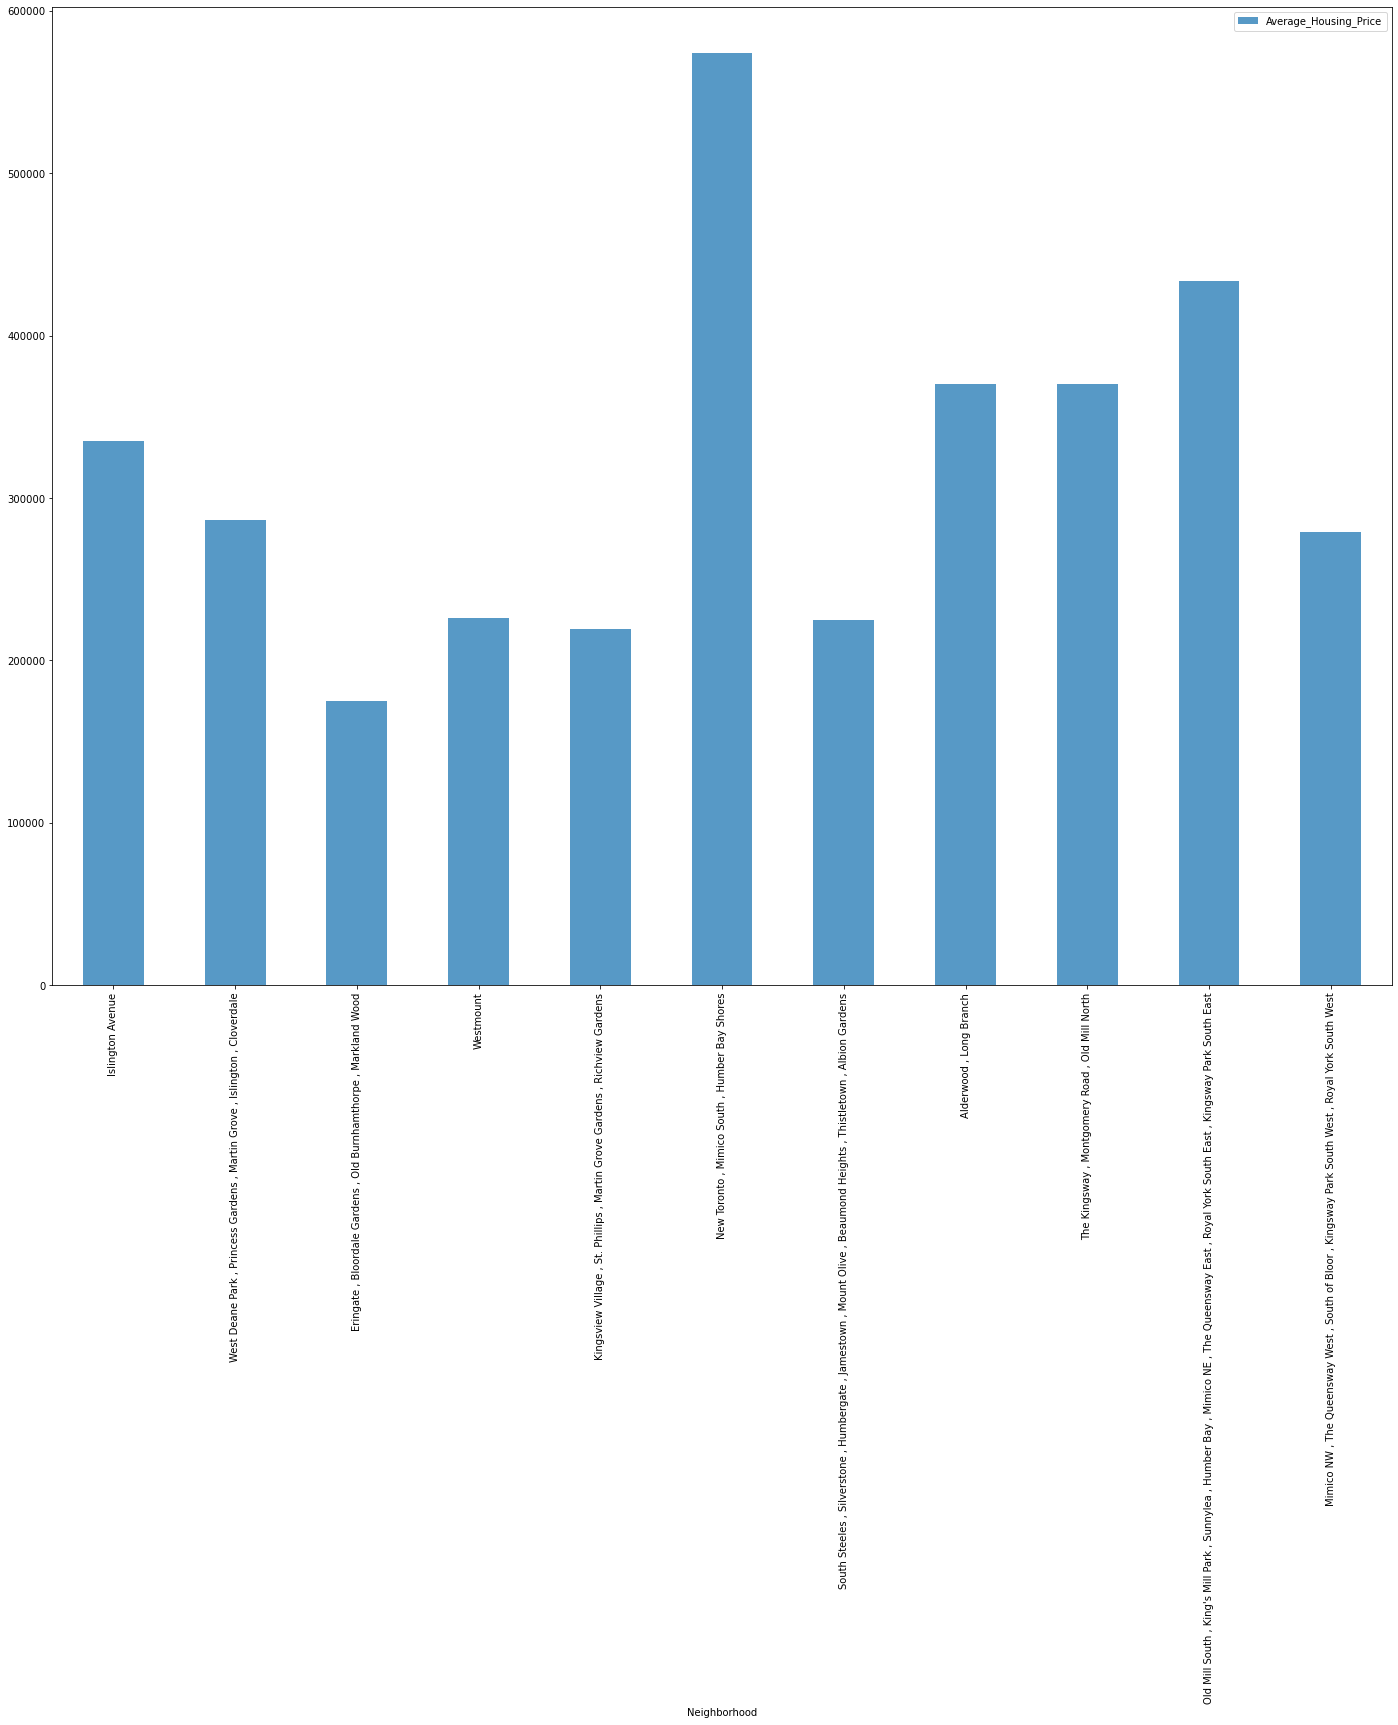

In [58]:
Etobicoke_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

## School Rating by Clusters

In [59]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [63]:
new_Etobicoke=Etobicoke_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Etobicoke_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [64]:
Etobicoke_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

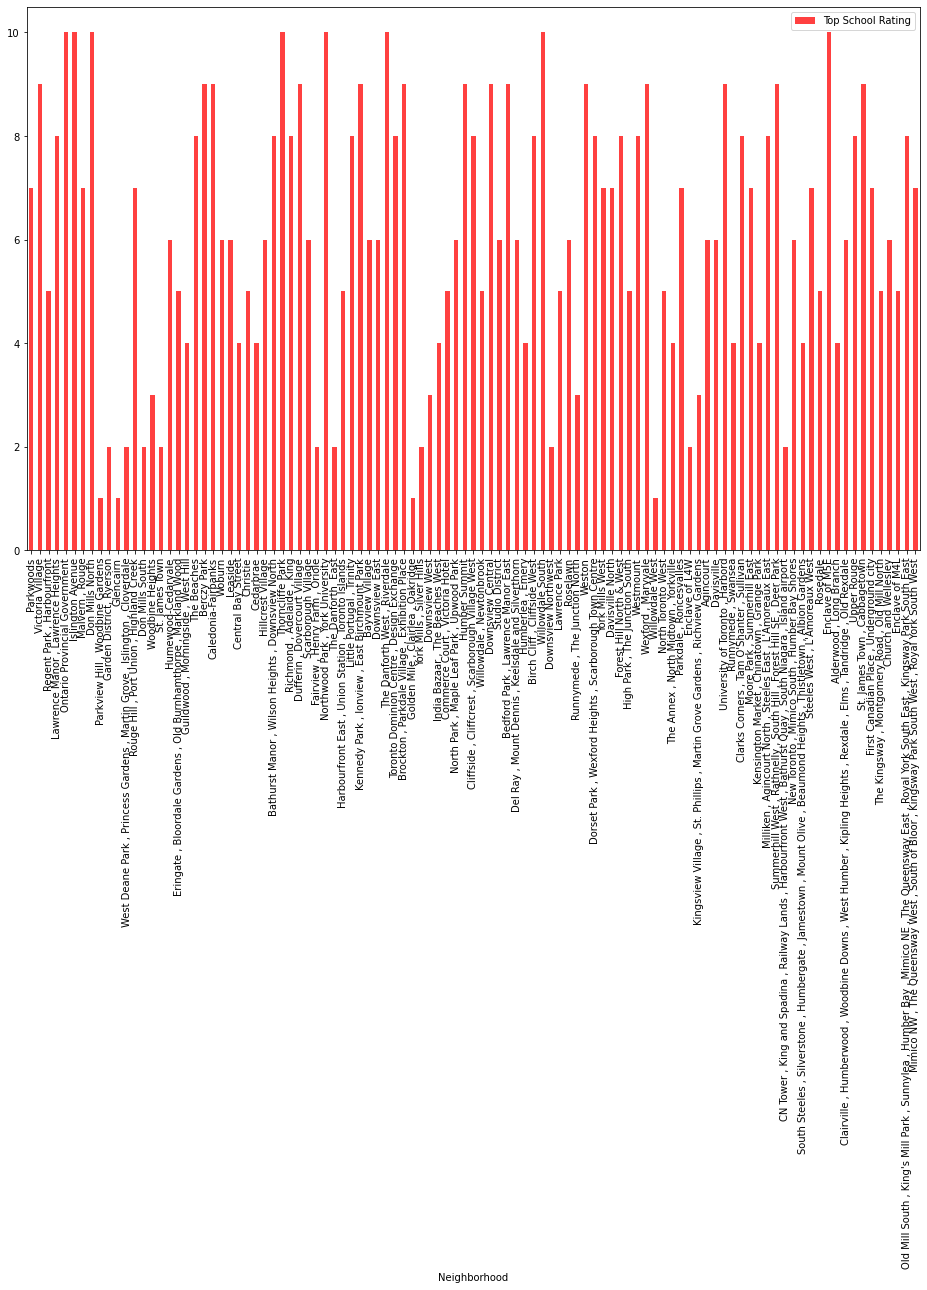

In [66]:
Etobicoke_school_ratings.plot(kind='bar',figsize=(16,10),color='red',alpha=0.75);

Conclusion: In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 11 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.